In [1]:
# Necessary Imports
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import entropy

/home/kwilliams/dev/stolen-probability-ptl/venv-torch-1.12.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Batch Stats

## `n_heads_16`

In [2]:
# Load KHull Batch Statistics From Disk
EXPERIMENT_DIR = Path('./experiments/embed_dim_64/n_heads_16')
hull_stats_list = []

for path in EXPERIMENT_DIR.glob('*/khull-batch-stats-*.csv'):
    layer_no = str(path)[-5]
    stats = pd.read_csv(path)
    stats['layer_idx'] = layer_no
    hull_stats_list.append(stats)

hull_stats = pd.concat(hull_stats_list)

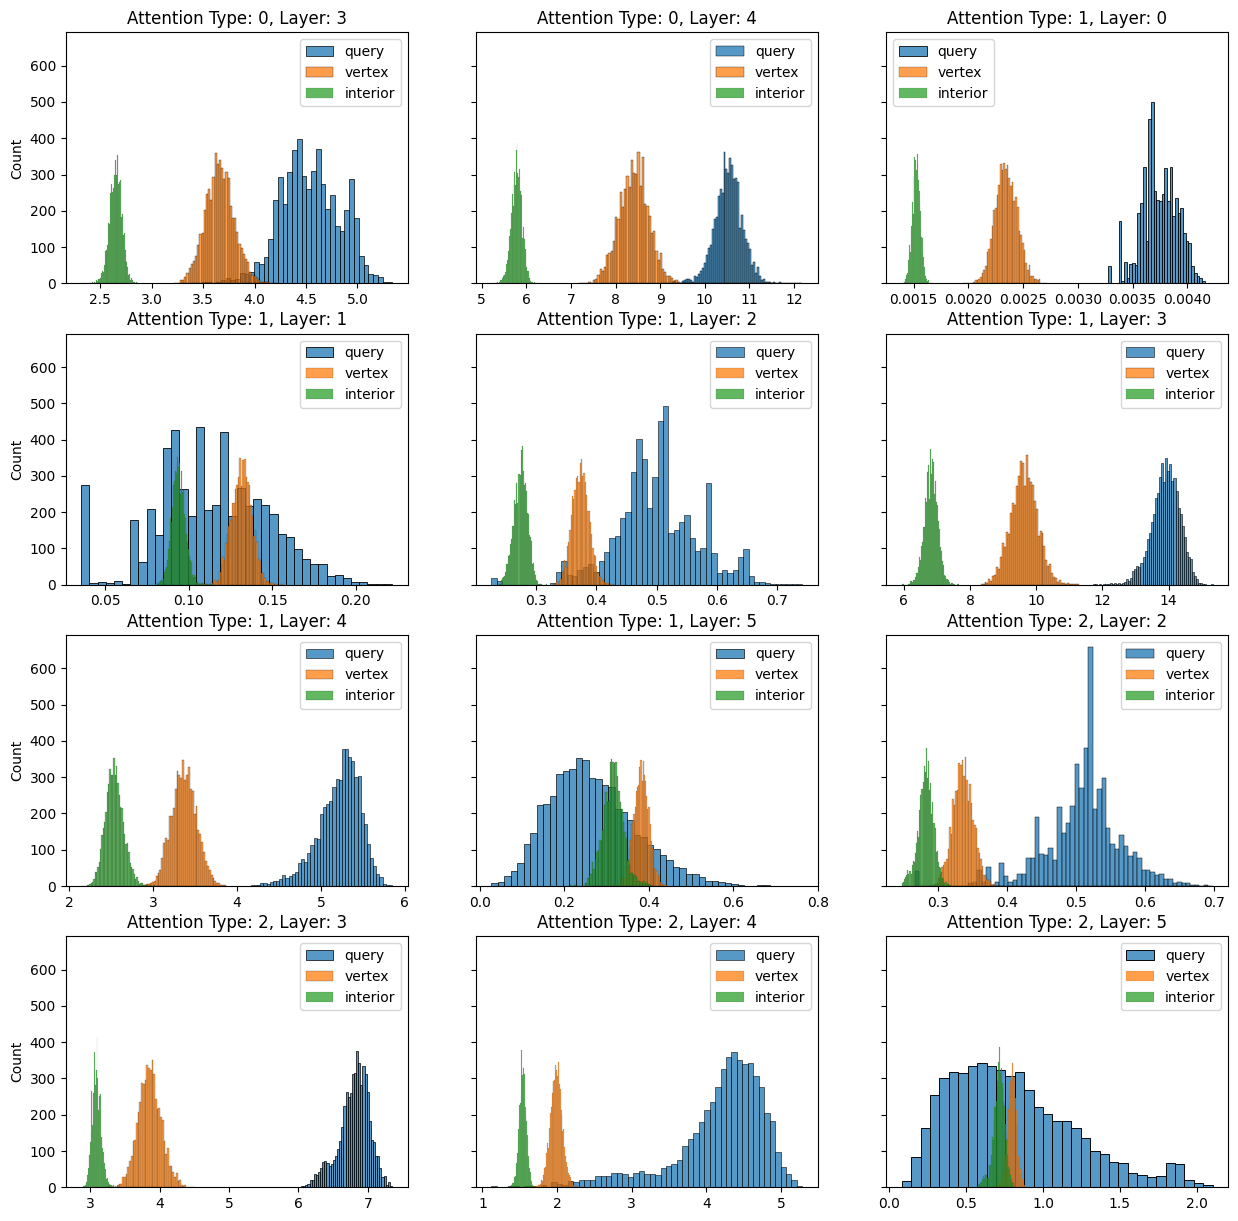

In [3]:
'''
What is the distibution of average embedding norm of K vectors for each layer of each model?
'''
# Set up subplots object
PLOTS_PER_ROW = 3
group_obj = hull_stats.groupby(by=['attn_norm', 'layer_idx'])
n_rows, n_cols = group_obj.ngroups // PLOTS_PER_ROW, PLOTS_PER_ROW
fig, ax = plt.subplots(n_rows, n_cols, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(15)

# Plot data for each group
for i, ((norm, layer_idx), data) in enumerate(group_obj):
    r, c = i // PLOTS_PER_ROW, i % PLOTS_PER_ROW
    sns.histplot(data=data, x='query_norm', ax=ax[r][c], label='query')
    sns.histplot(data=data, x='avg_norm_out', ax=ax[r][c], label='vertex')
    sns.histplot(data=data, x='avg_norm_in', ax=ax[r][c], label='interior')
    ax[r][c].set_title(f'Attention Type: {norm}, Layer: {layer_idx}')
    ax[r][c].set_xlabel('')
    ax[r][c].legend()

**Analysis:** As a sanity check, the distribution of norms for vertex/interior embeddings look Gaussian. This should be the case; law of large numbers suggests that the mean of a statistic is Gaussian-distributed when $n=30$. Here, $n$ is usually much larger than 30, as there are always at least 80 vertex embeddings. Furthermore, the vertex embeddings' mean is higher than that of interior points for all layers. However, the query vector seems to come from a much different distribution that is often outside the range of keys' norms. This suggests that the query is not often interior to the KHull of an attention head. 

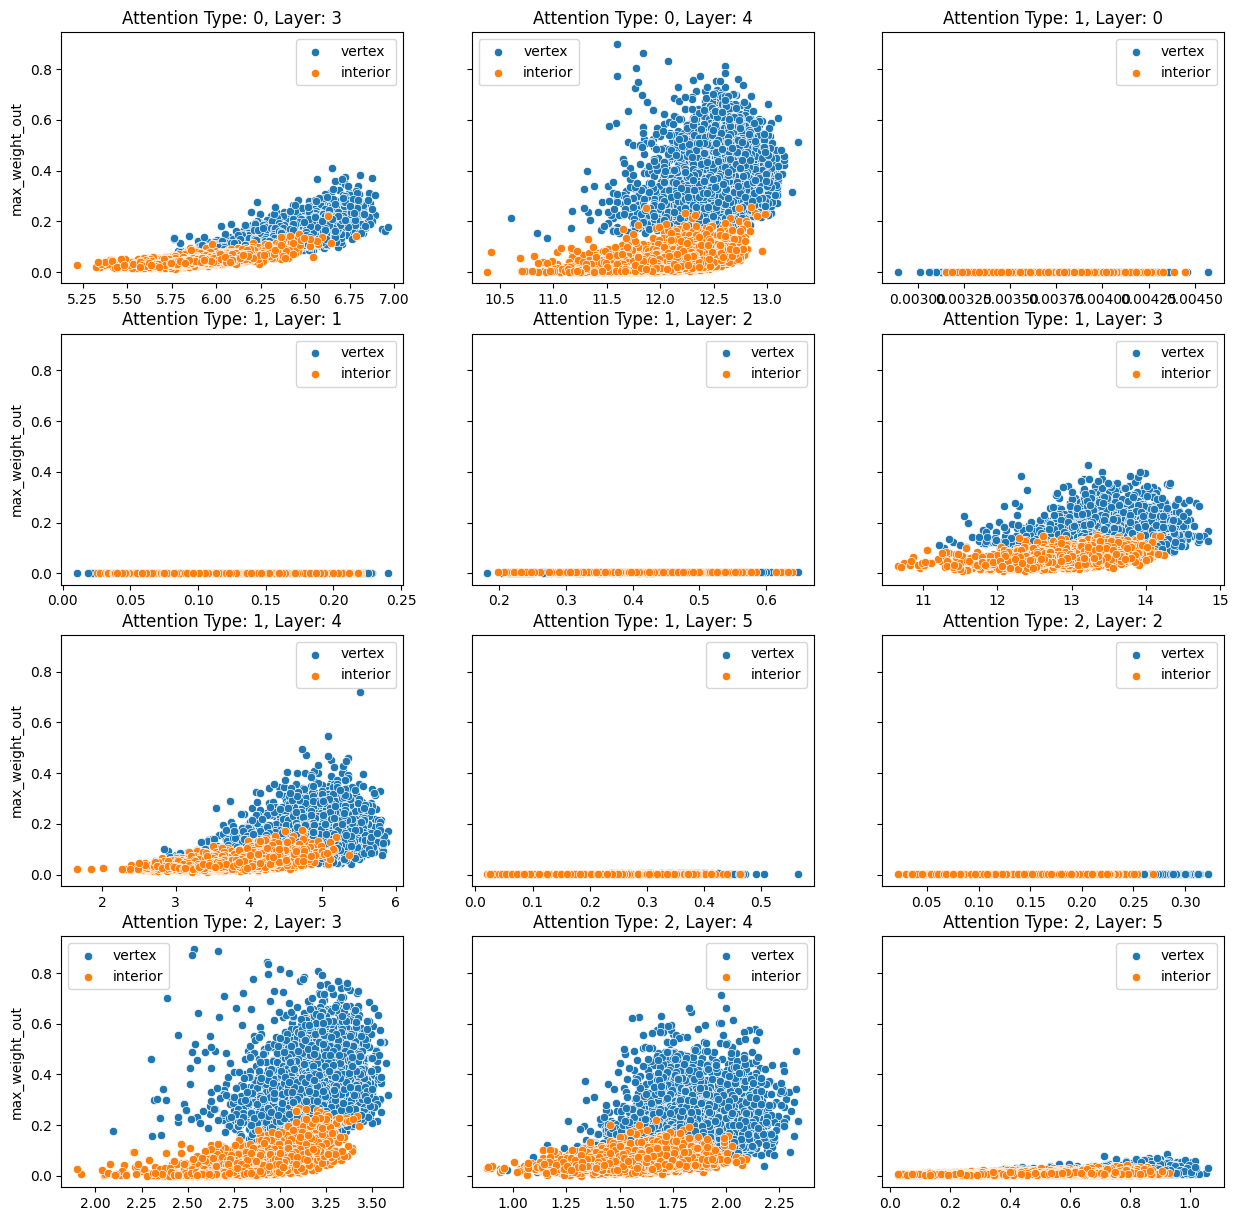

In [4]:
'''
For each model, what is the relationship between the largest weight assigned to a key vs. the norm of that key?
'''
# Set up subplots object
PLOTS_PER_ROW = 3
group_obj = hull_stats.groupby(by=['attn_norm', 'layer_idx'])
n_rows, n_cols = group_obj.ngroups // PLOTS_PER_ROW, PLOTS_PER_ROW
fig, ax = plt.subplots(n_rows, n_cols, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(15)

# Plot data for each group
for i, ((norm, layer_idx), data) in enumerate(group_obj):
    r, c = i // PLOTS_PER_ROW, i % PLOTS_PER_ROW
    sns.scatterplot(data=data, x='max_norm_out', y='max_weight_out', ax=ax[r][c], label='vertex')
    sns.scatterplot(data=data, x='max_norm_in', y='max_weight_in', ax=ax[r][c], label='interior')
    ax[r][c].set_title(f'Attention Type: {norm}, Layer: {layer_idx}')
    ax[r][c].set_xlabel('')
    ax[r][c].legend()

**Analysis:** What I'm plotting above is not great for comparing the overall maximum weight assigned over batches of the validation set. However, it usefully shows two things. 
1. There is a positive relationship between the maximum weight assigned to a key and its embedding norm. That is, the key with the largest attention weight is given a higher attention weight when its norm is larger. One question left to plot is how much larger the key's norm is compared to the average.
2. For all models, interior points' have their attention weights bounded. Even when an interior point has the same norm as a vertex point, the vertex point has a higher weight assigned. 

In [5]:
'''
With what proportion does each model assign its highest weight to a vertex key?
'''
hull_stats.groupby(['attn_norm', 'layer_idx'])['max_inside'].mean()

attn_norm  layer_idx
0          3            0.000000
           4            0.000000
1          0            0.485079
           1            0.779055
           2            0.237813
           3            0.001854
           4            0.009639
           5            0.575162
2          2            0.000371
           3            0.000000
           4            0.005561
           5            0.133086
Name: max_inside, dtype: float64

**Analysis:** I will have to be careful when applying Logistic Regression, as some layers of the `base` and `euc` models never assign their highest weight to an interior key. 

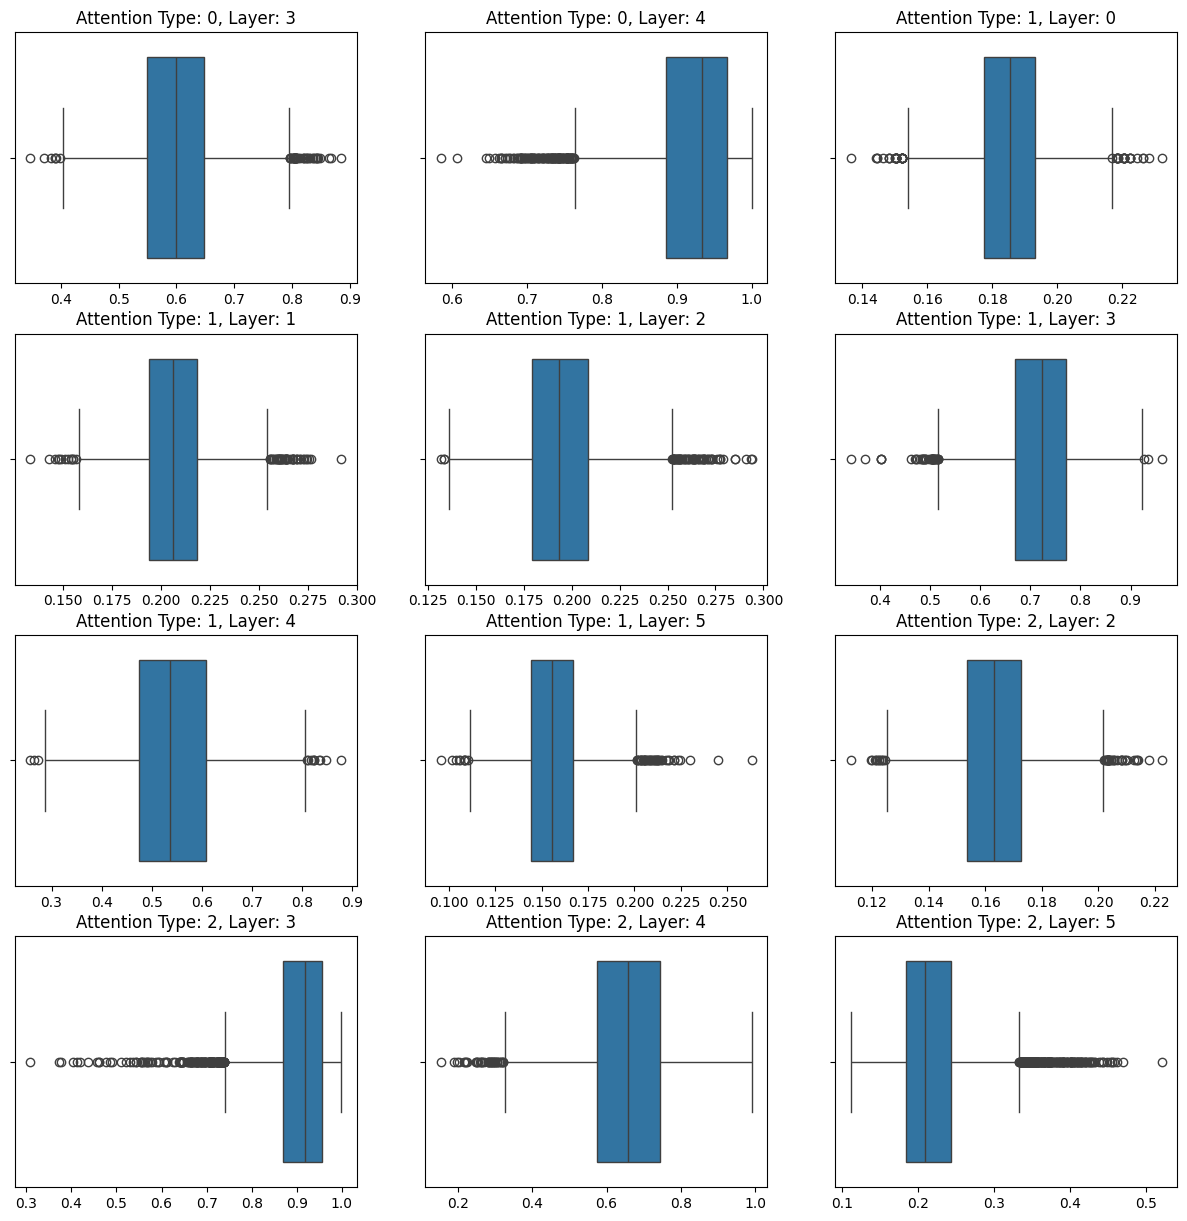

In [6]:
'''
For each model, what is the total weight assigned to vertex points?
'''
# Set up subplots object
PLOTS_PER_ROW = 3
group_obj = hull_stats.groupby(by=['attn_norm', 'layer_idx'])
n_rows, n_cols = group_obj.ngroups // PLOTS_PER_ROW, PLOTS_PER_ROW
fig, ax = plt.subplots(n_rows, n_cols, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(15)

# Plot data for each group
for i, ((norm, layer_idx), data) in enumerate(group_obj):
    r, c = i // PLOTS_PER_ROW, i % PLOTS_PER_ROW
    diff = data['avg_weight_out']*data['n_vertices']
    sns.boxplot(x=diff, ax=ax[r][c])
    ax[r][c].set_title(f'Attention Type: {norm}, Layer: {layer_idx}')
    ax[r][c].set_xlabel('')

**Analysis:** This might be my most telling plot so far. In general, I would expect the majority of attention mass to be assigned to interior points. This is for two reasons. One, there are many more interior points over which to distribute attention. Second, query norms are rarely inside the KHull; all interior points will be closer to the query than vertex points on the opposide side of the hull. Yet, the `base` model does not display this behavior. Instead, the vertices in Layers 3 and 4 get the majority of the attention mass (Layer 4 is especially biased). In the `man` and `euc` models, Layers 3 and 4 are also biased to give the majority of attention mass to vertices. Because these attention heads line up, I wonder if the determinism of my training scheme has given them similar roles in distinguishing tokens. Regardless, the other layers of the `man` and `euc` models are much less extreme, and give the majority of attention to interior tokens the majority of the time. 

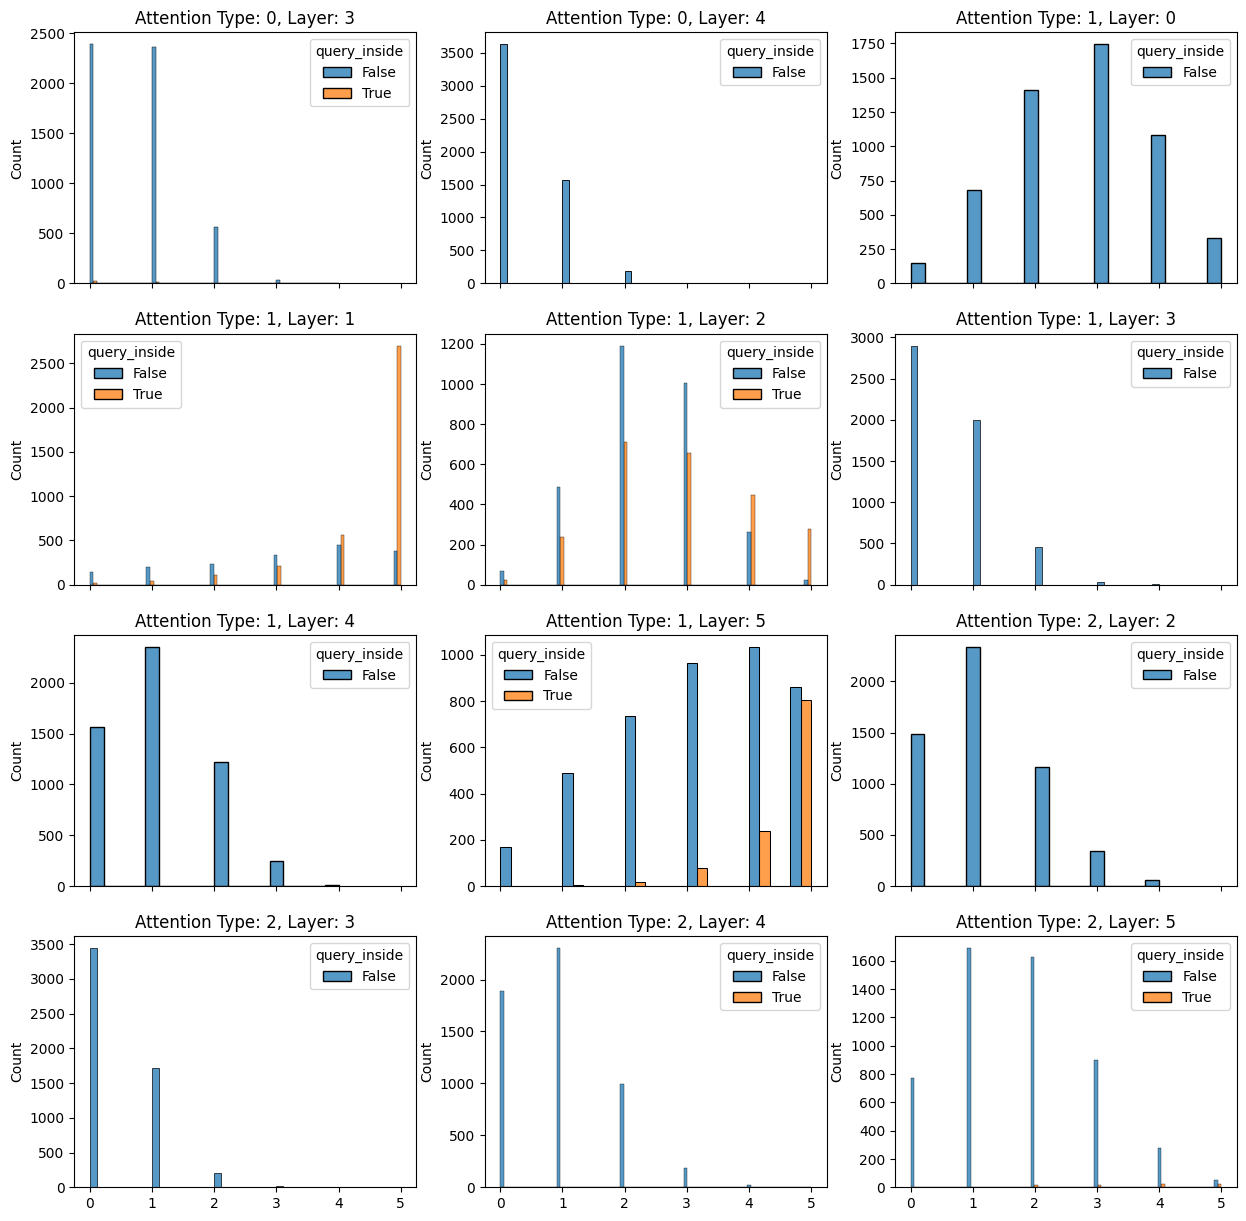

In [7]:
'''
How many interior vectors make up the top 5 keys with the highest attention weights?
'''
# Set up subplots object
PLOTS_PER_ROW = 3
group_obj = hull_stats.groupby(by=['attn_norm', 'layer_idx'])
n_rows, n_cols = group_obj.ngroups // PLOTS_PER_ROW, PLOTS_PER_ROW
fig, ax = plt.subplots(n_rows, n_cols, sharex=True)
fig.set_figwidth(15)
fig.set_figheight(15)

# Plot data for each group
for i, ((norm, layer_idx), data) in enumerate(group_obj):
    r, c = i // PLOTS_PER_ROW, i % PLOTS_PER_ROW
    sns.histplot(data=data, x='n_inside_top5', multiple='dodge', hue='query_inside', ax=ax[r][c])
    ax[r][c].set_title(f'Attention Type: {norm}, Layer: {layer_idx}')
    ax[r][c].set_xlabel('')

**Analysis:** The query vector is very infrequently located inside the KHull of a model's layer's attention head. However, when it is, more interior vectors appear in the top 5 attention weights. For example, see Layer 1 of Manhattan attention, where the top 5 keys are almost always interior vectors when the query is inside the KHull. 

In [8]:
'''
With what proportion does each model assign its highest weight to a vertex key?
'''
hull_stats.groupby(['attn_norm', 'layer_idx'])['n_interior'].mean() / 512

attn_norm  layer_idx
0          3            0.796136
           4            0.825481
1          0            0.814759
           1            0.789371
           2            0.811512
           3            0.799727
           4            0.796486
           5            0.836269
2          2            0.831262
           3            0.793675
           4            0.824986
           5            0.817891
Name: n_interior, dtype: float64

## `1_layer_1_head`

In [9]:
# Load KHull Batch Statistics From Disk
EXPERIMENT_DIR = Path('./experiments/one_layer')
hull_stats_list = []

for path in EXPERIMENT_DIR.glob('*/khull-batch-stats-*.csv'):
    layer_no = str(path)[-5]
    stats = pd.read_csv(path)
    hull_stats_list.append(stats)

hull_stats = pd.concat(hull_stats_list)
hull_stats['attn_norm'] = hull_stats['attn_norm'].fillna(0)

ValueError: No objects to concatenate

In [ ]:
hull_stats.describe()

,batch_no,attn_norm,n_heads,n_vertices,n_interior,query_norm,max_weight_in,max_norm_in,max_weight_out,max_norm_out,...,avg_norm_in,avg_weight_out,avg_norm_out,avg_weight_all_top5,avg_norm_all_top5,avg_weight_in_top5,avg_norm_in_top5,avg_weight_out_top5,avg_norm_out_top5,n_inside_top5
count,3162.000000,3162.000000,3162.0,3162.0,3162.0,3162.000000,0.0,0.0,3162.000000,3162.000000,...,0.0,3.162000e+03,3162.000000,3162.000000,3162.000000,0.0,0.0,3162.000000,3162.000000,3162.0
mean,134784.000000,1.000000,1.0,512.0,0.0,1.793964,NaN,NaN,0.020337,1.847135,...,NaN,1.953125e-03,2.062356,0.017310,1.821494,NaN,NaN,0.017310,1.821494,0.0
std,77903.764182,0.816626,0.0,0.0,0.0,0.868710,NaN,NaN,0.005665,1.323421,...,NaN,1.156644e-10,0.196019,0.004069,1.242861,NaN,NaN,0.004069,1.242861,0.0
min,0.000000,0.000000,1.0,512.0,0.0,0.322266,NaN,NaN,0.010144,0.601074,...,NaN,1.953125e-03,1.780273,0.009319,0.668000,NaN,NaN,0.009319,0.668000,0.0
25%,67328.000000,0.000000,1.0,512.0,0.0,0.922485,NaN,NaN,0.015959,0.899048,...,NaN,1.953125e-03,1.809570,0.014105,0.942250,NaN,NaN,0.014105,0.942250,0.0
50%,134784.000000,1.000000,1.0,512.0,0.0,1.763184,NaN,NaN,0.018993,0.995605,...,NaN,1.953125e-03,2.103516,0.015988,1.017000,NaN,NaN,0.015988,1.017000,0.0
75%,202240.000000,2.000000,1.0,512.0,0.0,2.789062,NaN,NaN,0.024100,3.567871,...,NaN,1.953125e-03,2.248047,0.020745,3.496000,NaN,NaN,0.020745,3.496000,0.0
max,269568.000000,2.000000,1.0,512.0,0.0,3.511719,NaN,NaN,0.048836,4.394531,...,NaN,1.953125e-03,2.554688,0.034921,4.004000,NaN,NaN,0.034921,4.004000,0.0


**Description:** Here, we're stacking the results from the same 1054 validation batches sent through `one_layer/base`, `one_layer/man`, and `one_layer/euc`. As such, the dataframe has 3162 rows. Recall that these models each have one layer and one head to make comparisons more direct. The stats were collected with a window length of 512; interestingly, `n_vertices=512` for all batches of all models. The fact that no keys are interior to the K hull is way different than the previous models I've analyzed. Perhaps just having a single head causes the transformer to spread its embeddings as far as possible. 

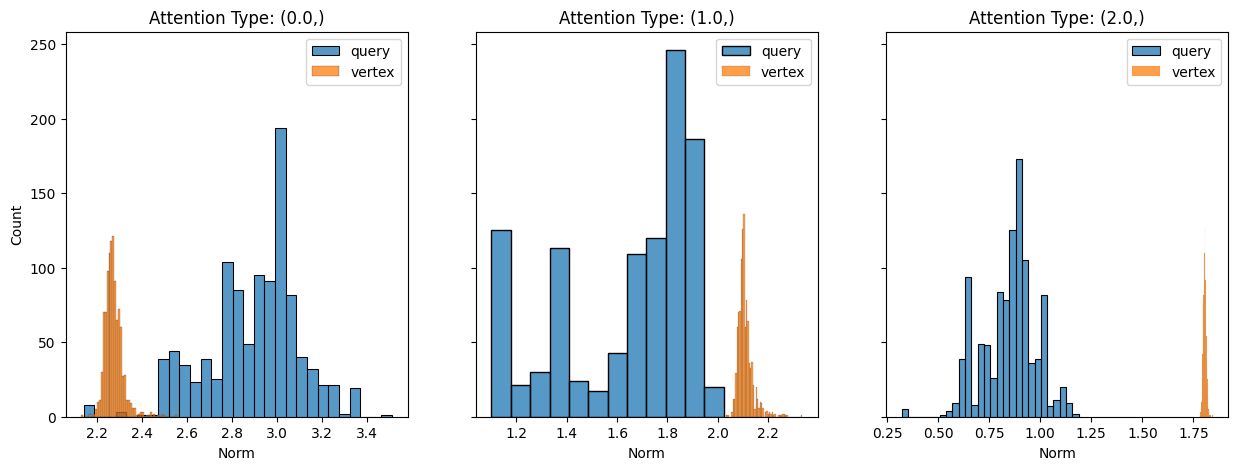

In [ ]:
'''
What is the distibution of average embedding norm of K vectors for each layer of each model?
'''
# Set up subplots object
group_obj = hull_stats.groupby(by=['attn_norm'])
n_plots = group_obj.ngroups
fig, ax = plt.subplots(1, n_plots, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(5)

# Plot data for each group
for i, (norm, data) in enumerate(group_obj):
    sns.histplot(data=data, x='query_norm', ax=ax[i], label='query')
    sns.histplot(data=data, x='avg_norm_out', ax=ax[i], label='vertex')
    ax[i].set_title(f'Attention Type: {norm}')
    ax[i].set_xlabel('Norm')
    ax[i].legend()

In [ ]:
'''
How often is the query inside the K hull of each model?
'''
# Set up subplots object
group_obj = hull_stats.groupby(by=['attn_norm'])
group_obj['query_inside'].mean()

attn_norm
0.0    0.0
1.0    0.0
2.0    0.0
Name: query_inside, dtype: float64

**Analysis:** The query is never inside the K Hull of any model. This is weird to see, especially given that the norm of the query is almost always less than the average norm of keys in the non-dot-product models. 

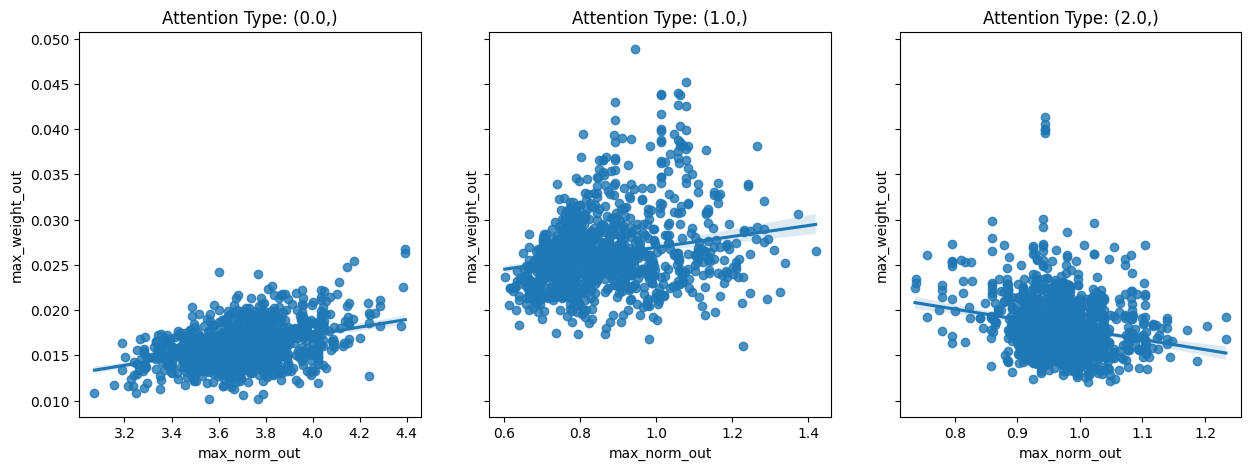

In [ ]:
'''
For each model, what is the relationship between the largest weight assigned to a key vs. the norm of that key?
'''
# Set up subplots object
group_obj = hull_stats.groupby(by=['attn_norm'])
n_plots = group_obj.ngroups
fig, ax = plt.subplots(1, n_plots, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(5)

# Plot data for each group
for i, (norm, data) in enumerate(group_obj):
    sns.regplot(data=data, x='max_norm_out', y='max_weight_out', ax=ax[i], robust=True)
    ax[i].set_title(f'Attention Type: {norm}')

## `1_layer_8_heads`

In [2]:
# Load KHull Batch Statistics From Disk
EXPERIMENT_DIR = Path('./experiments/1_layer_8_heads')
hull_stats = {}

for i in range(8):
    stats_list = []
    for path in EXPERIMENT_DIR.glob(f'*/khull-batch-stats-head{i}.csv'):
        stats_list.append(pd.read_csv(path))
    stats_df = pd.concat(stats_list)
    stats_df['attn_norm'] = stats_df['attn_norm'].fillna(0.0)
    hull_stats[i] = stats_df

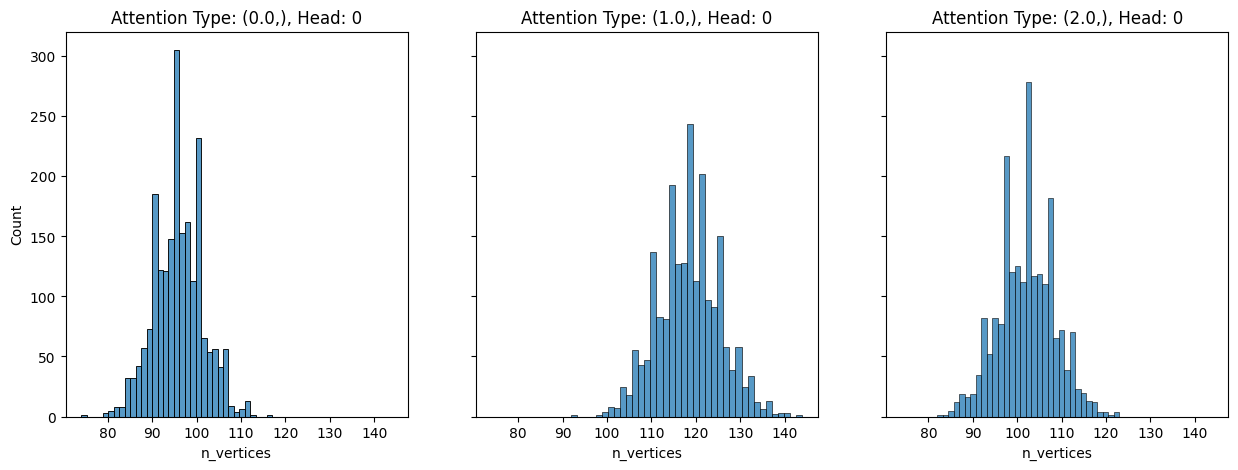

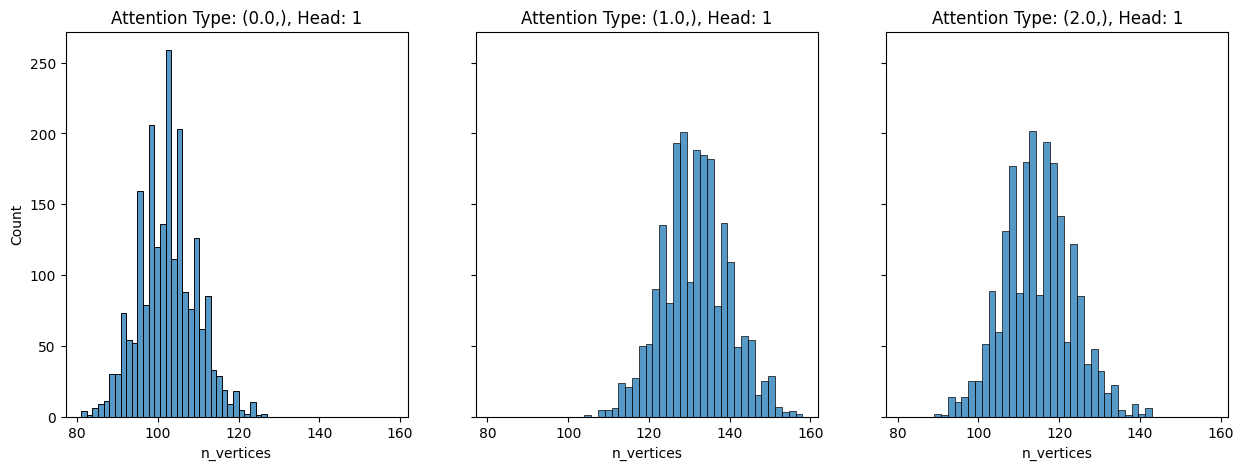

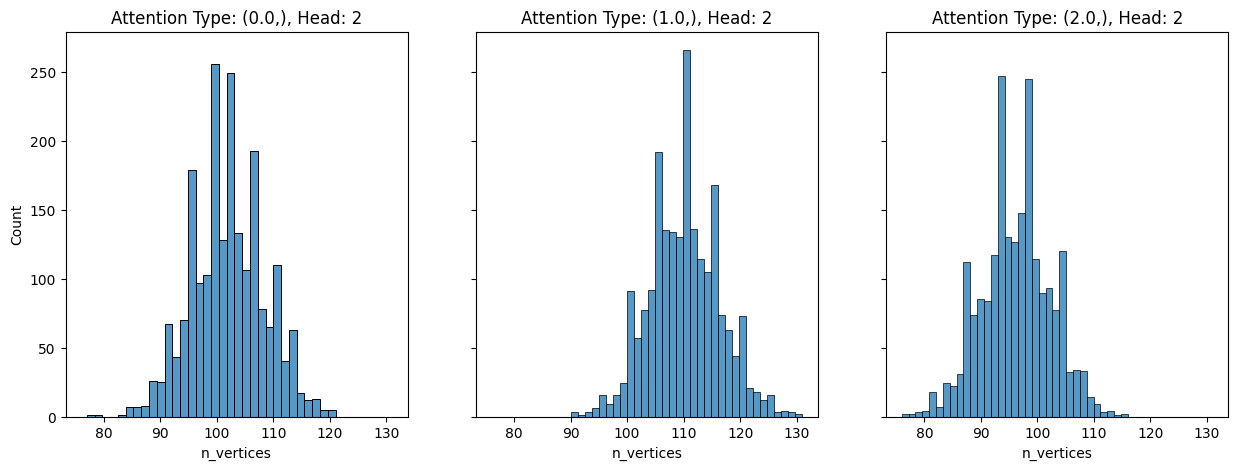

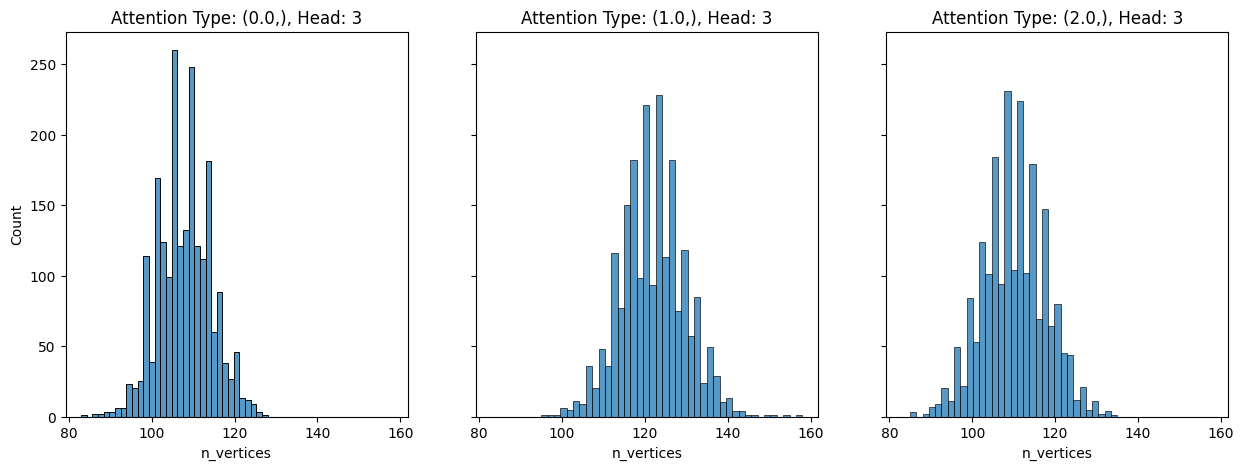

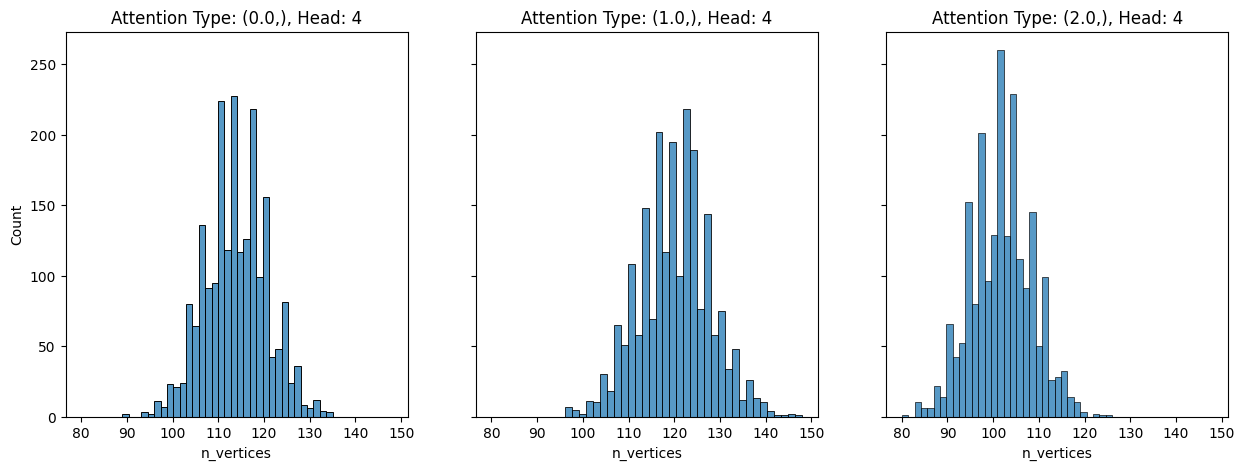

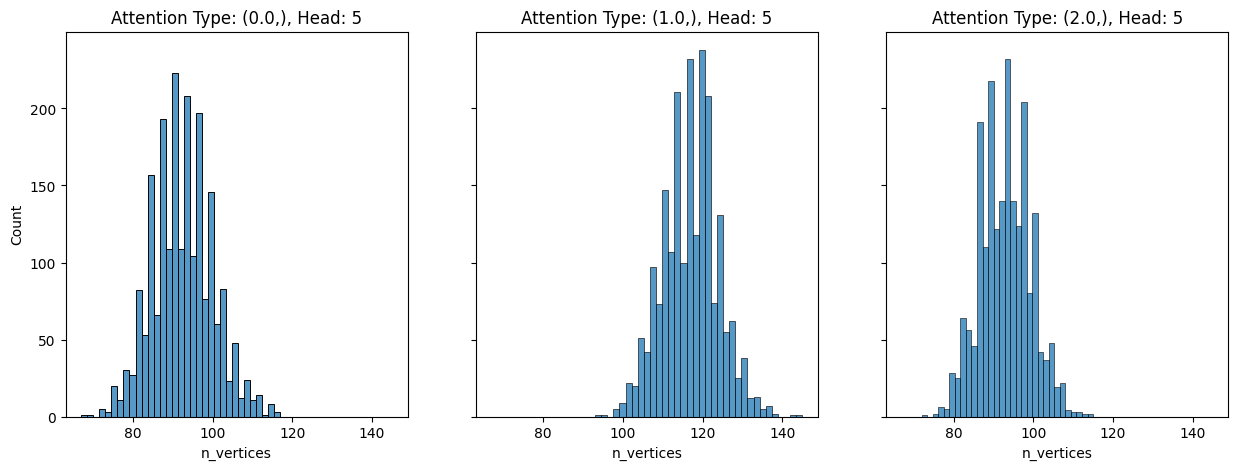

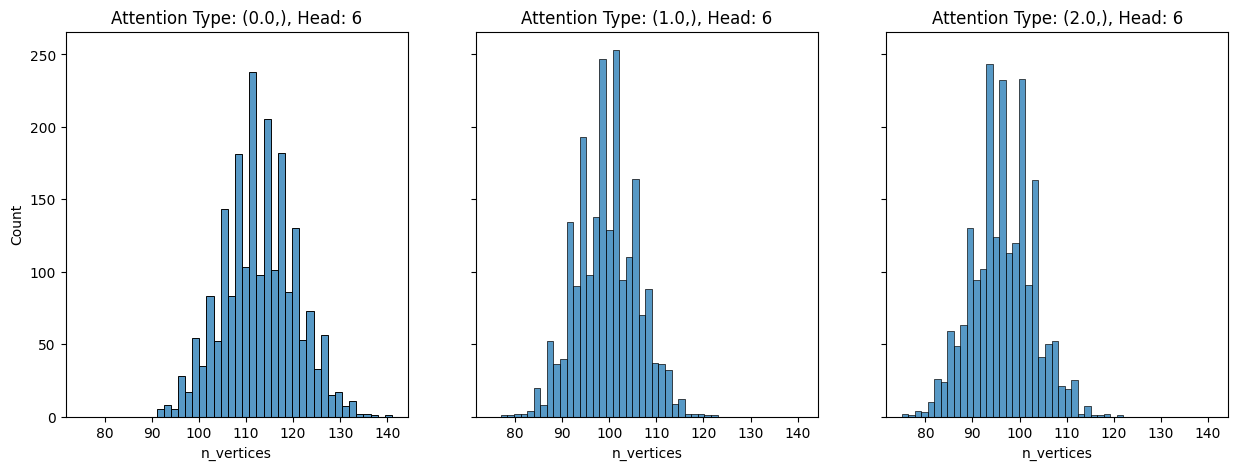

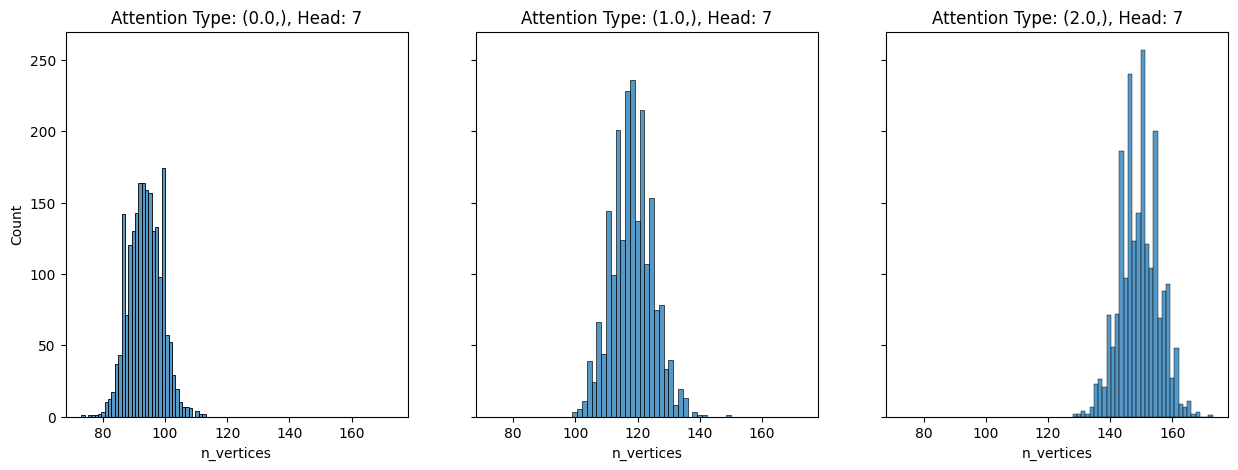

In [ ]:
'''
In each head of each model, how many keys are inside the convex hull on average?
'''
# Each model has 8 heads. Make a separate subplot to compare the same head of different models
for i in range(8):
    group_obj = hull_stats[i].groupby(['attn_norm'])

    fig, ax = plt.subplots(1, len(group_obj), sharex=True, sharey=True)
    fig.set_figwidth(15)
    fig.set_figheight(5)

    # Plot data for head i of each of 3 models 
    for j, (norm, data) in enumerate(group_obj):
        sns.histplot(data=data, x='n_vertices', ax=ax[j])
        ax[j].set_title(f'Attention Type: {norm}, Head: {i}')

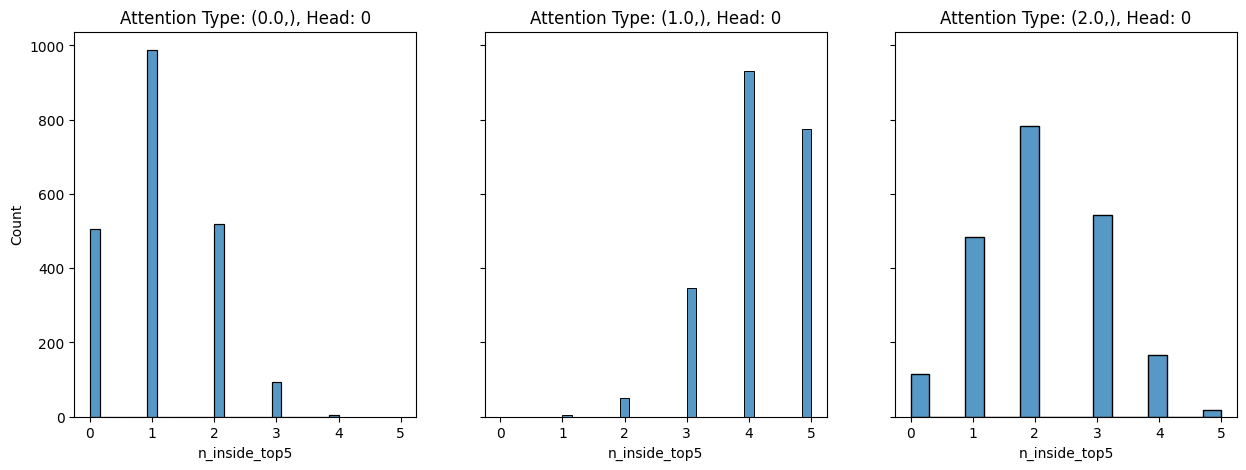

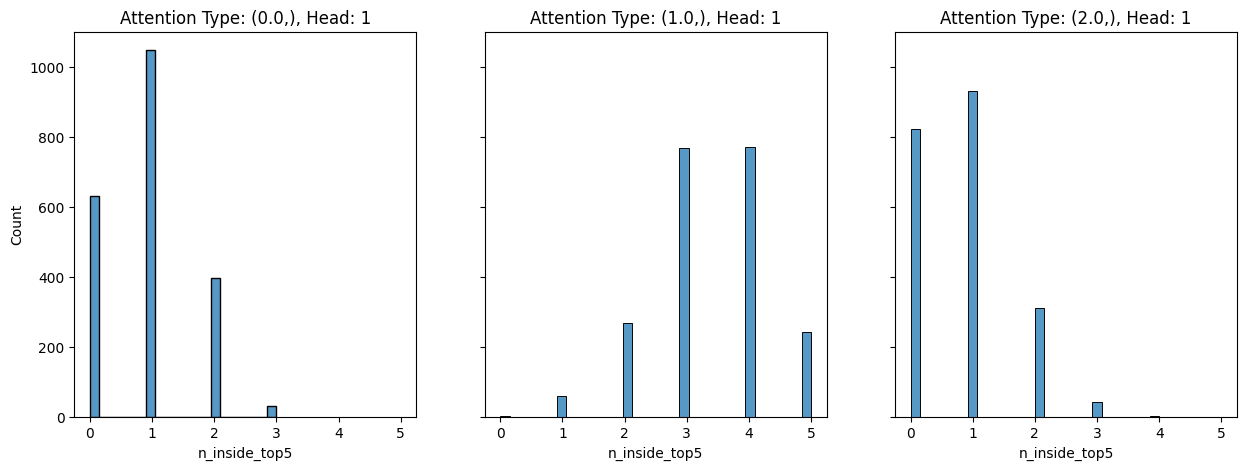

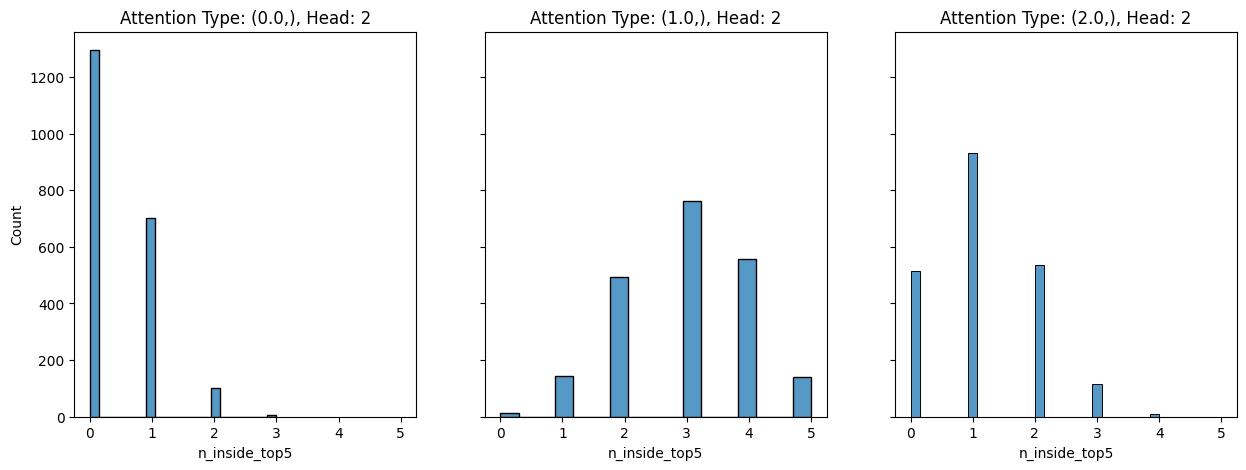

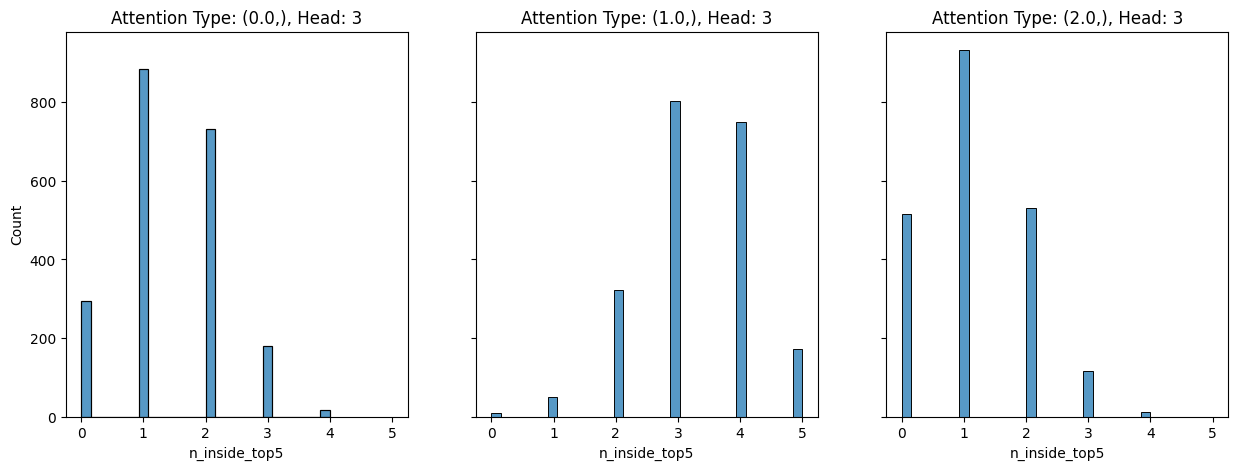

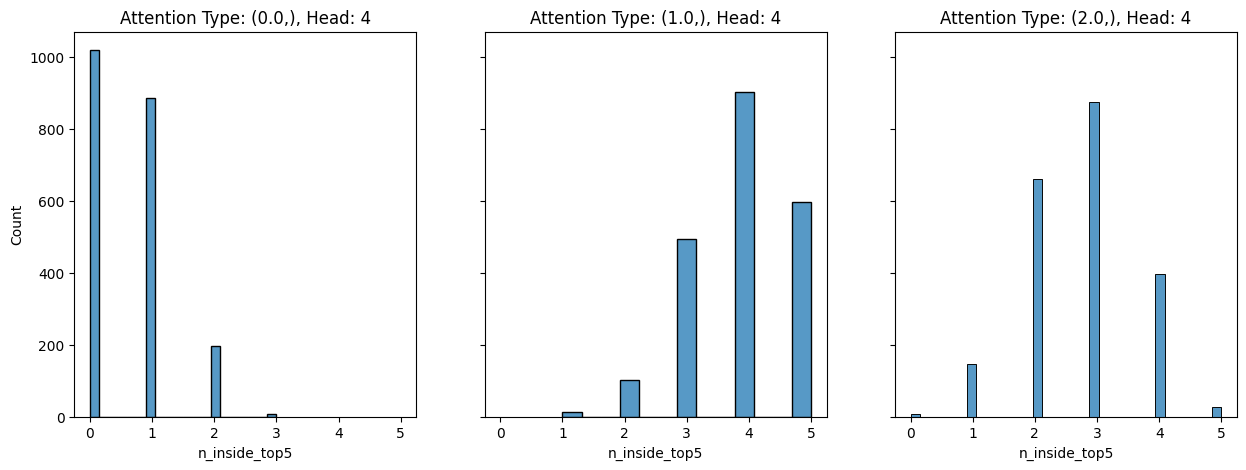

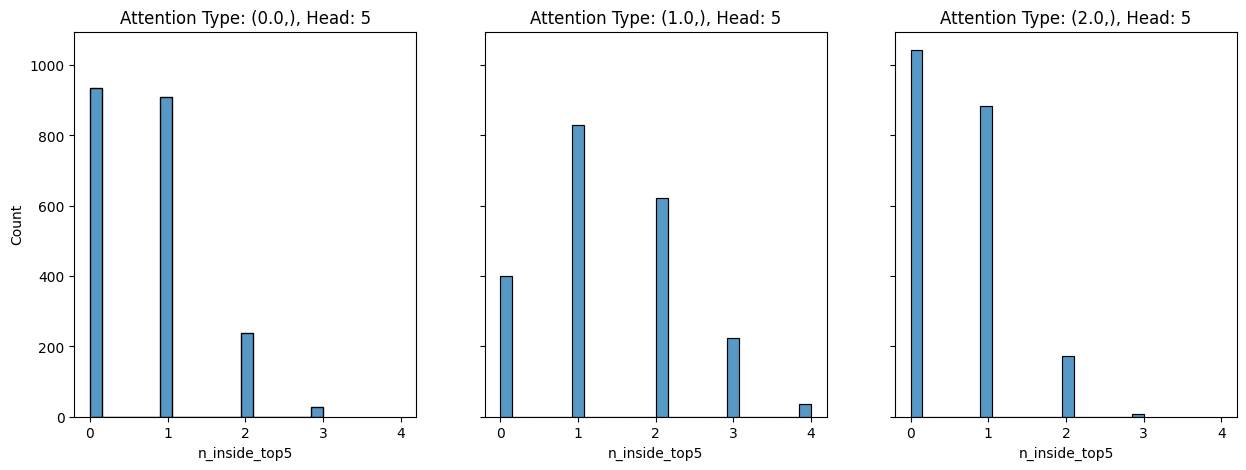

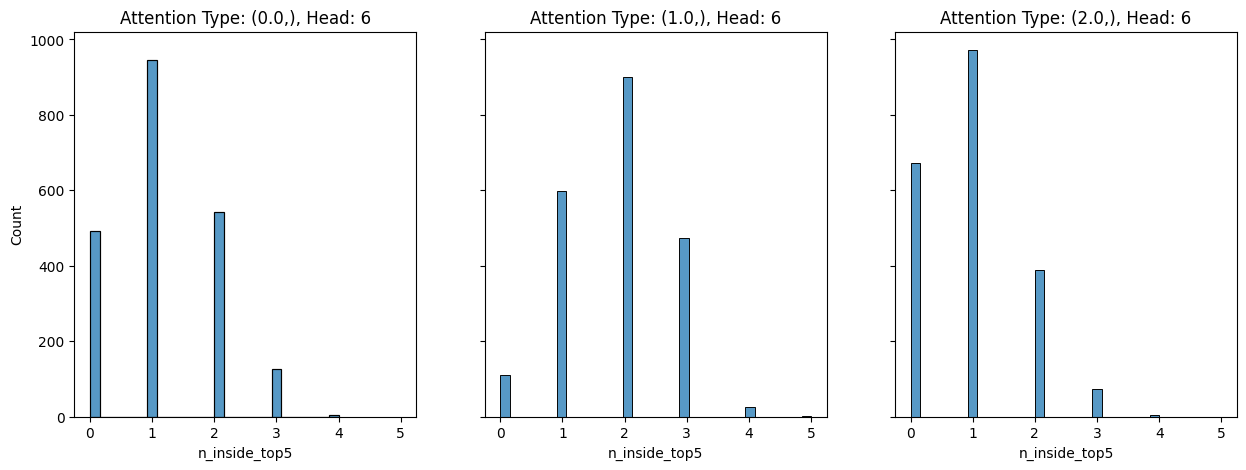

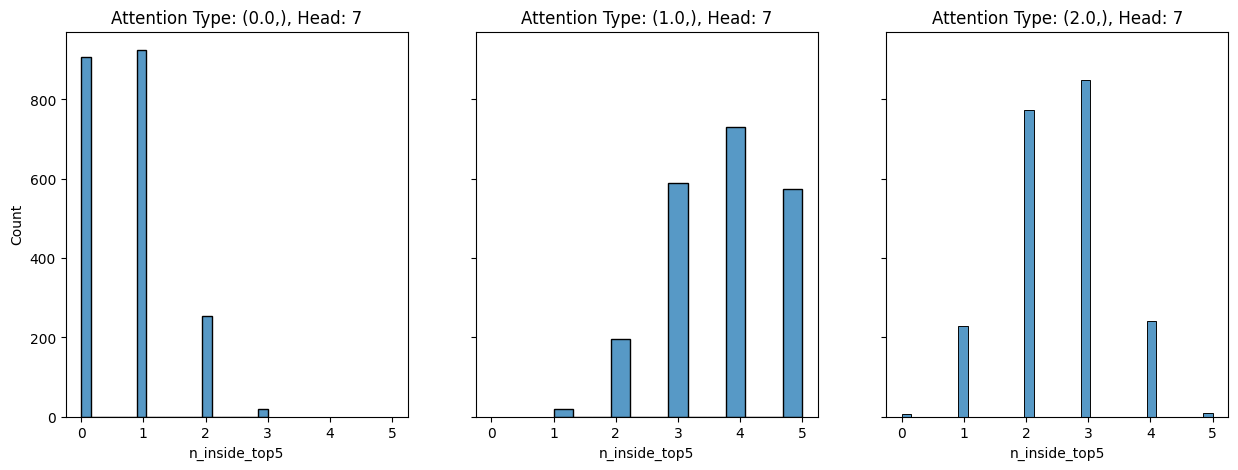

In [ ]:
'''
In each head of each model, how many keys with the top 5 attention weights are interior to the convex hull?
'''
# Each model has 8 heads. Make a separate subplot to compare the same head of different models
for i in range(8):
    group_obj = hull_stats[i].groupby(['attn_norm'])

    fig, ax = plt.subplots(1, len(group_obj), sharex=True, sharey=True)
    fig.set_figwidth(15)
    fig.set_figheight(5)

    # Plot data for head i of each of 3 models 
    for j, (norm, data) in enumerate(group_obj):
        sns.histplot(data=data, x='n_inside_top5', ax=ax[j])
        ax[j].set_title(f'Attention Type: {norm}, Head: {i}')

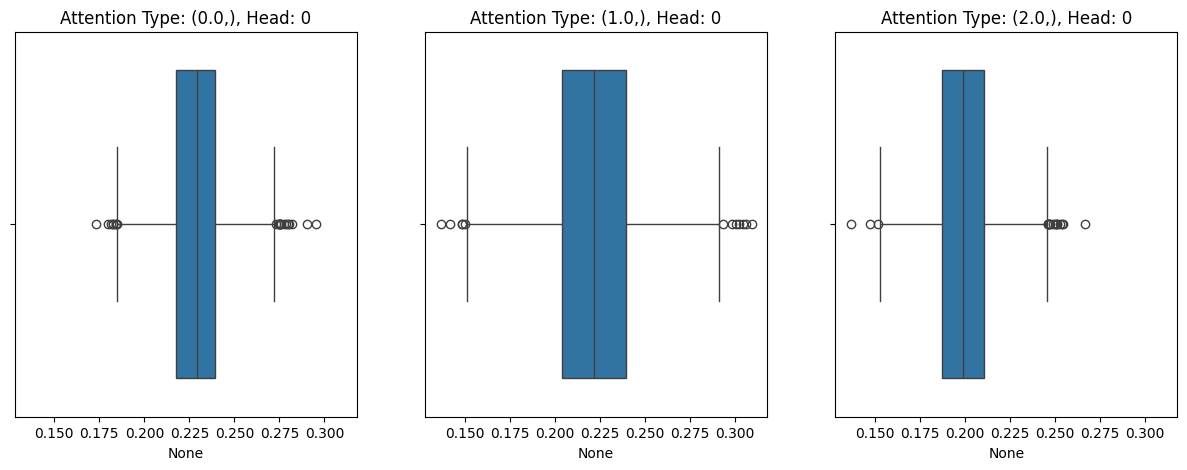

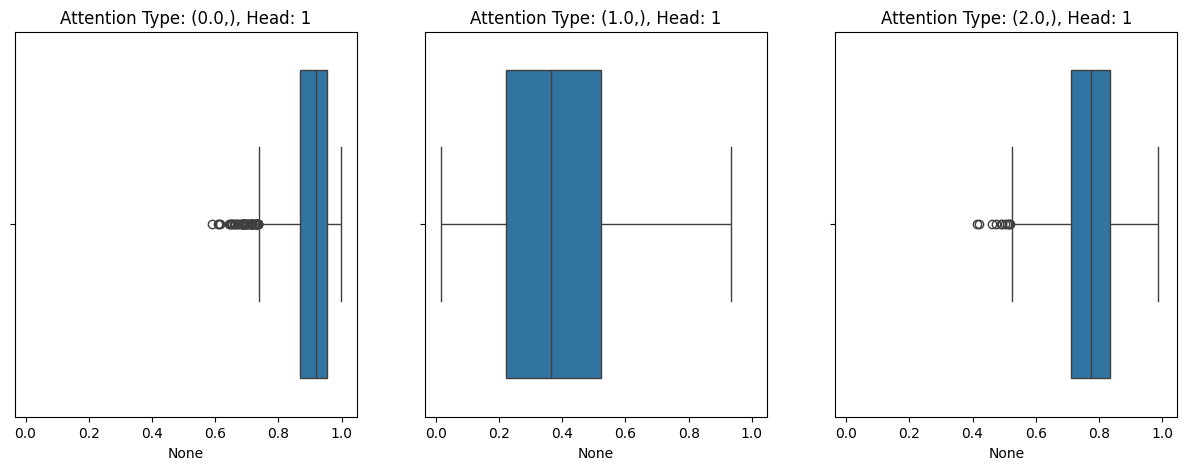

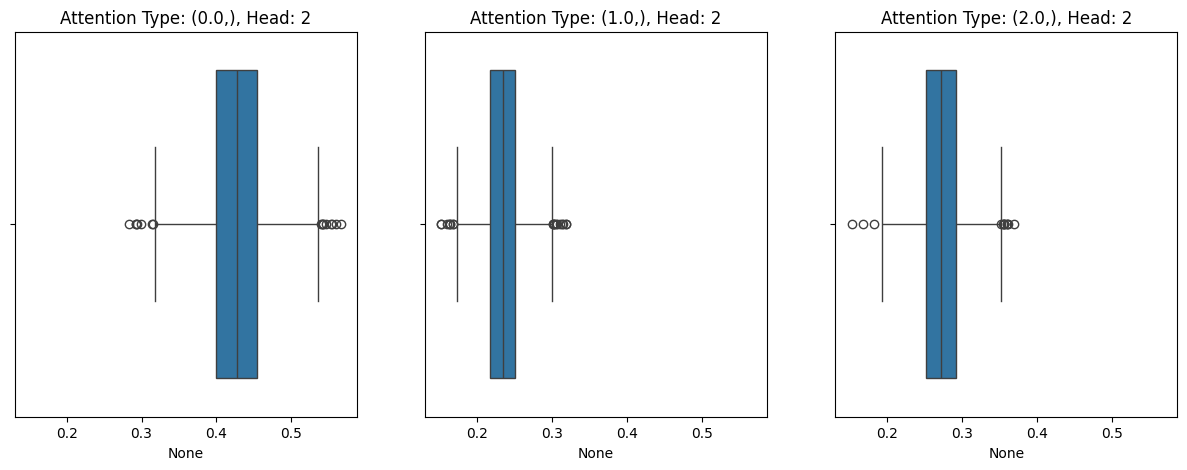

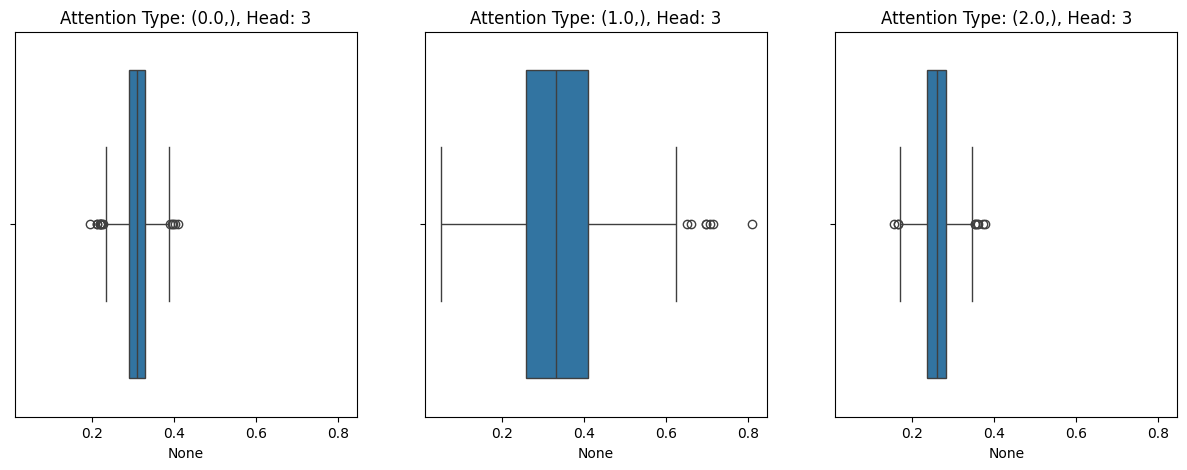

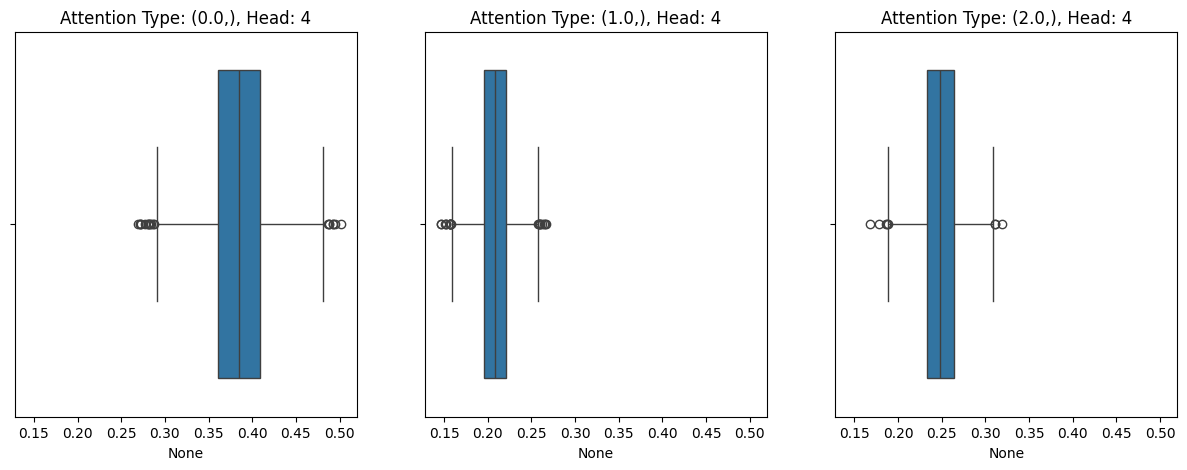

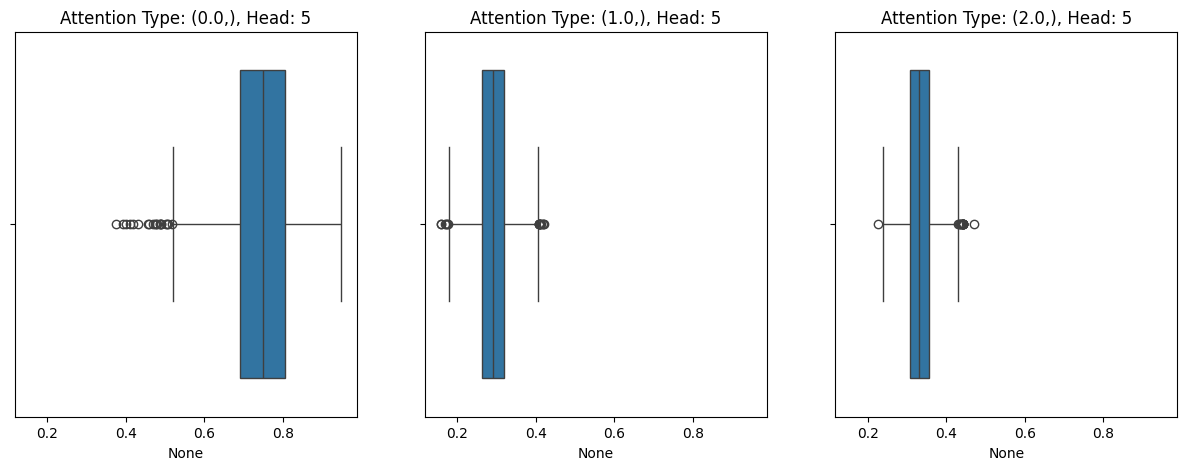

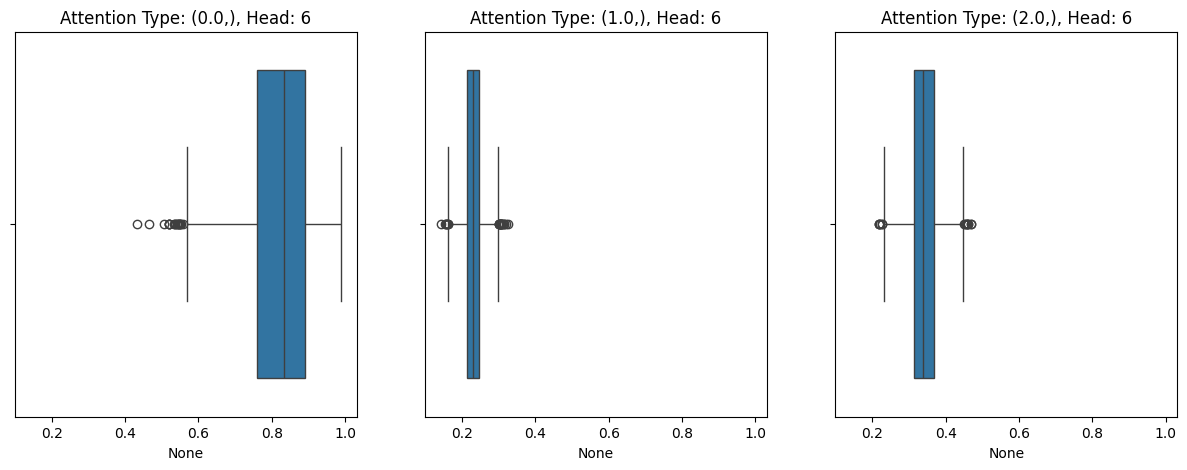

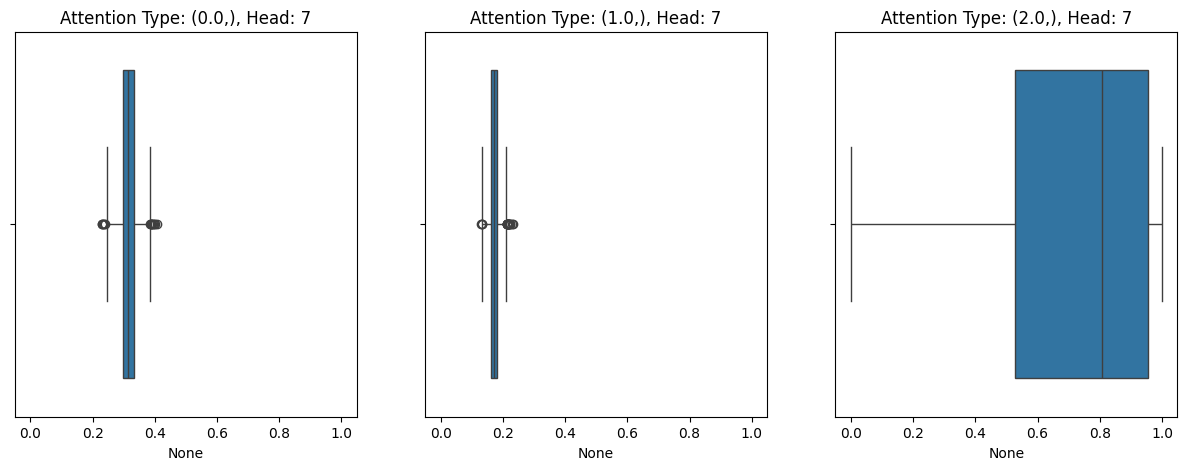

In [ ]:
'''
For each model, what is the distribution of total weight assigned to vertex points?
'''
# Each model has 8 heads. Make a separate subplot to compare the same head of different models
for i in range(8):
    group_obj = hull_stats[i].groupby(['attn_norm'])

    fig, ax = plt.subplots(1, len(group_obj), sharex=True, sharey=True)
    fig.set_figwidth(15)
    fig.set_figheight(5)

    # Plot data for head i of each of 3 models 
    for j, (norm, data) in enumerate(group_obj):
        total_weight = data['avg_weight_out']*data['n_vertices']
        sns.boxplot(x=total_weight, ax=ax[j])
        ax[j].set_title(f'Attention Type: {norm}, Head: {i}')

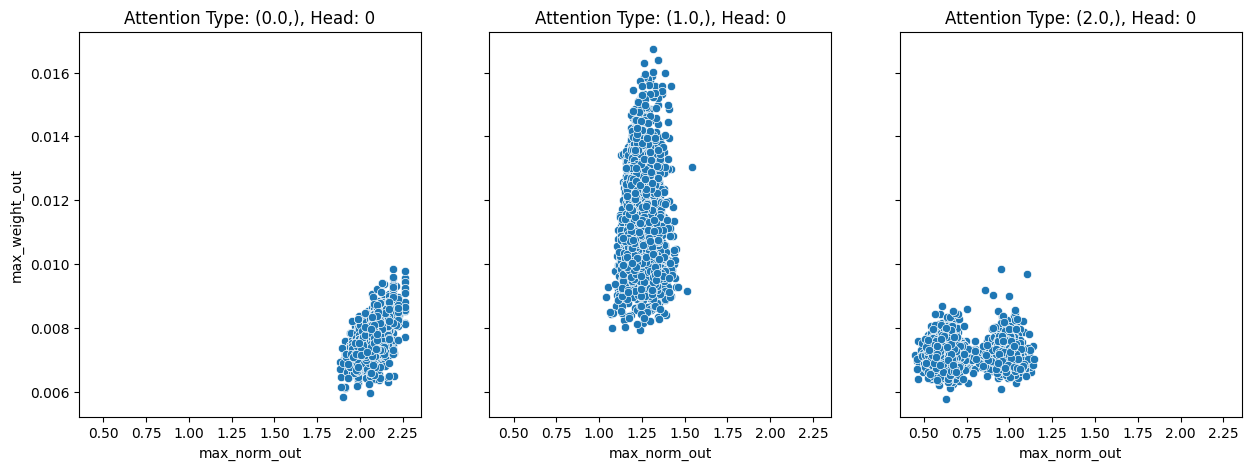

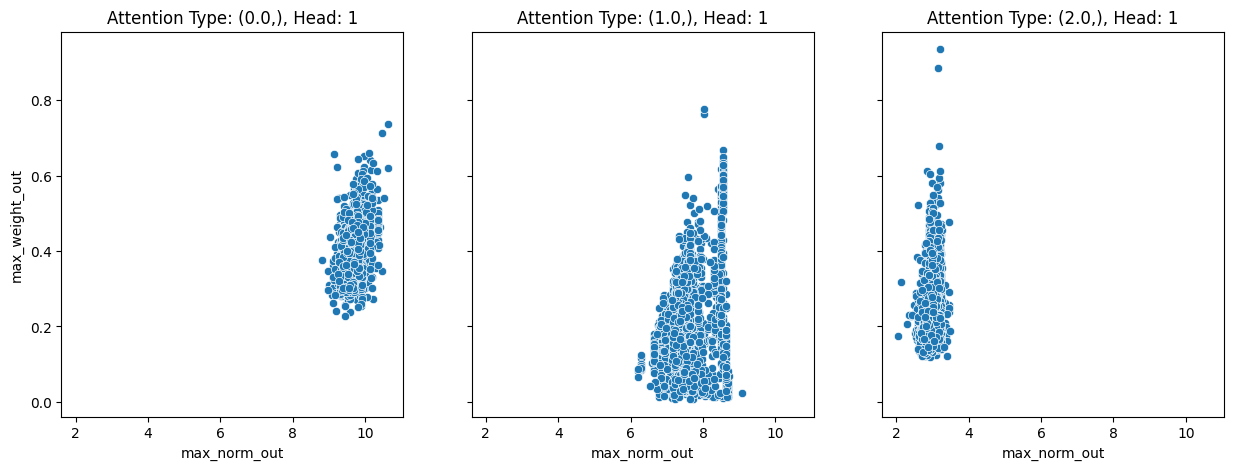

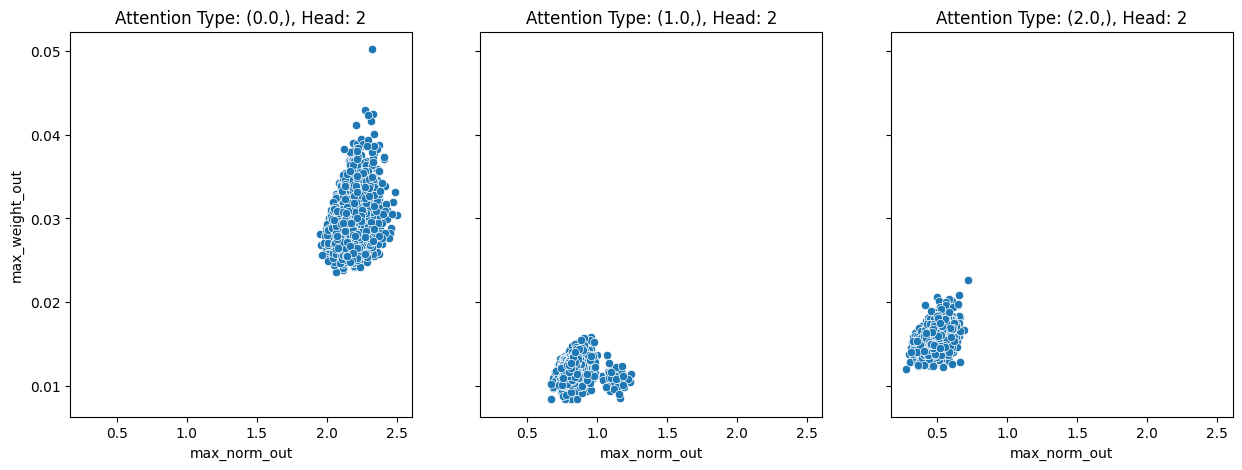

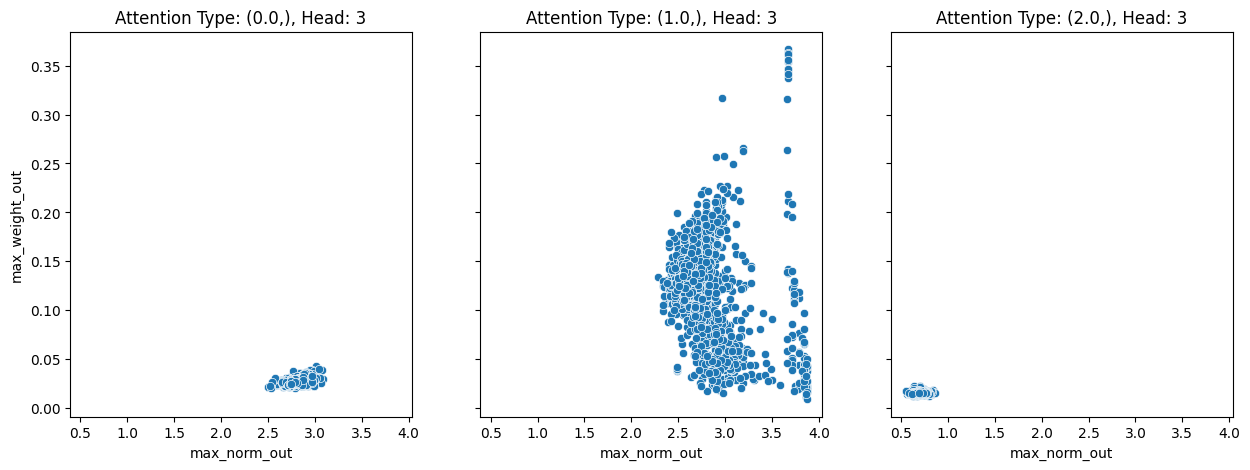

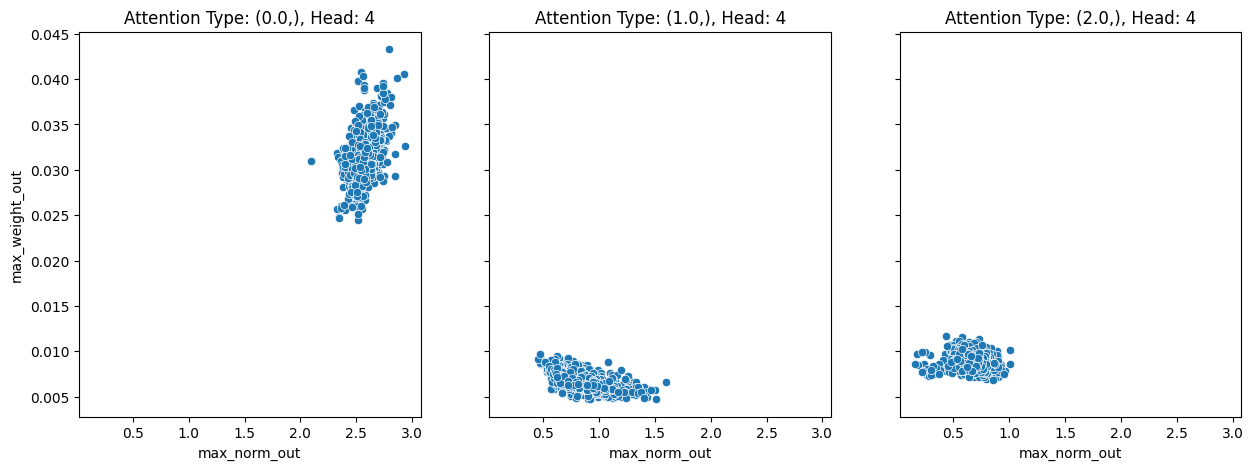

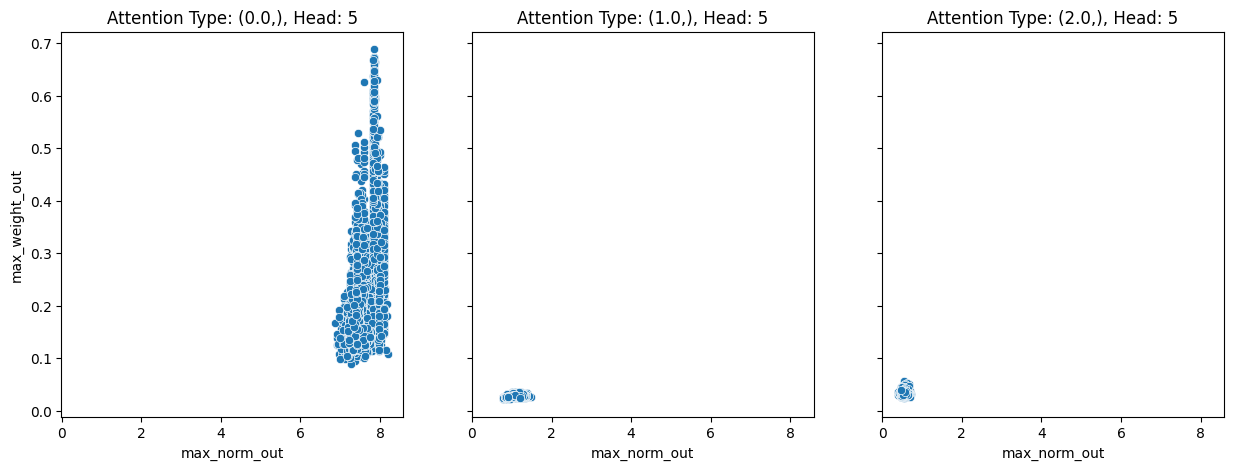

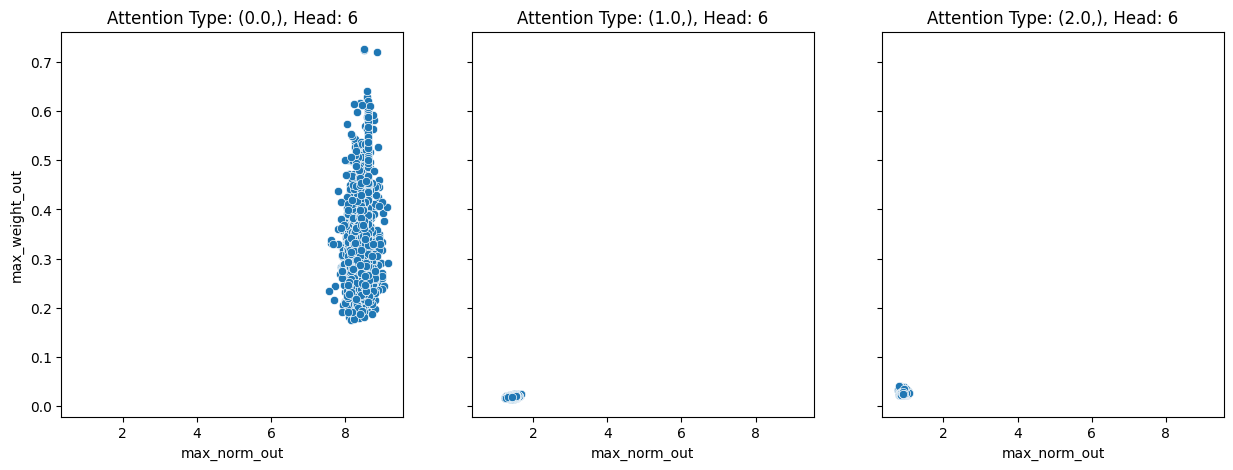

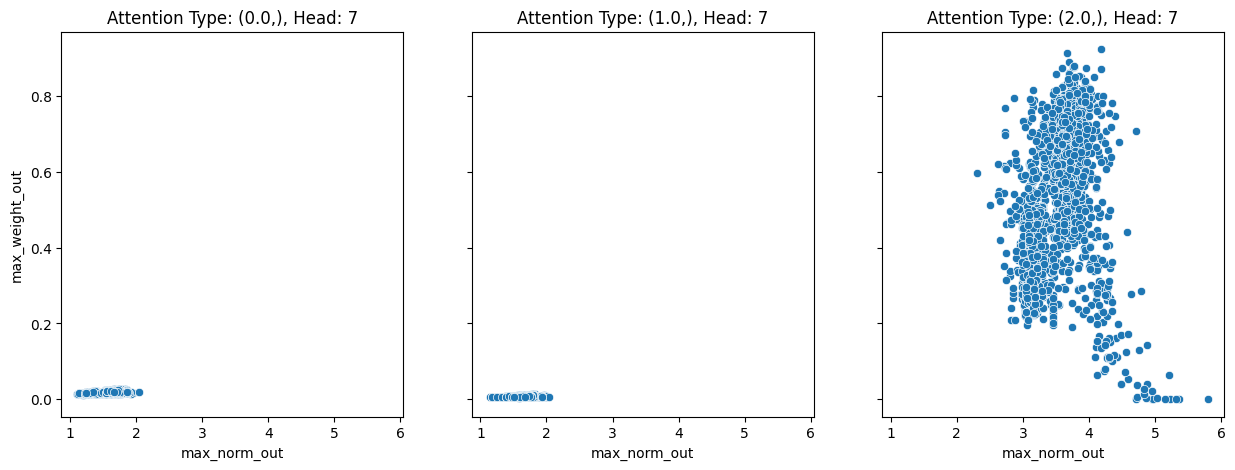

In [5]:
'''
For each model, what is the distribution of total weight assigned to vertex points?
'''
# Each model has 8 heads. Make a separate subplot to compare the same head of different models
for i in range(8):
    group_obj = hull_stats[i].groupby(['attn_norm'])

    fig, ax = plt.subplots(1, len(group_obj), sharex=True, sharey=True)
    fig.set_figwidth(15)
    fig.set_figheight(5)

    # Plot data for head i of each of 3 models 
    for j, (norm, data) in enumerate(group_obj):
        sns.scatterplot(data=data, x='max_norm_out', y='max_weight_out', ax=ax[j])
        ax[j].set_title(f'Attention Type: {norm}, Head: {i}')

# KL Divergences

In [ ]:
# Load Attention Weight Assignments over Batches From Disk
EXPERIMENT_DIR = Path('./experiments/one_layer')
weights = {}

for path in EXPERIMENT_DIR.glob('*/attn_weights-*-stride=128.npy'):
    weights[path.parts[-2]] = np.load(path)

In [ ]:
# Calculate KL Divergence between the models' weights and the oracle's weights for each batch
# NOTE: Oracle should be P to quantify information loss when using Q to approximate P
kl_div = pd.DataFrame()
kl_div['base'] = entropy(weights['oracle'], qk=weights['base'], axis=1)
kl_div['euc'] = entropy(weights['oracle'], qk=weights['euc'], axis=1)
kl_div['man'] = entropy(weights['oracle'], qk=weights['man'], axis=1)

In [ ]:
# NOTE: 0 means the distributions have the exact same information, so lower is better
kl_div.mean()

base    1.505333
euc     1.329801
man     1.575621
dtype: float32

**Analysis:** Recall that KL divergence is a measure of information loss when Q approximates P. Given the above, for an average batch, the `euc` model best approximates the attention distribution of the `oracle`. Interestingly, `man` is worse than `base` in this setup. 

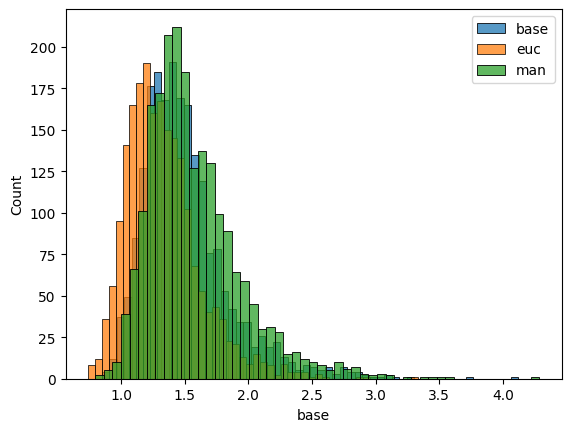

: 

In [ ]:
for column in kl_div.columns:
    sns.histplot(data=kl_div, x=column, label=column)
    plt.legend()